In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sps

# Grid walk

Given an $x-\textrm{by}-x$ grid, start in the lower left corner. Reach the upper right corner by moving only up or right. How many unique valid walks exist?

Every valid walk has a length of $2x$, and can be encoded as a sequence of that many bits. The valid bit sequences are those of length $2x$ in which exactly $x$ bits are flipped to $1$. The total count of such sequences $c$ can be calculated as:
\begin{align}
c = \binom{2x}{x}
\end{align}

### basic definitions

In [2]:
# def ncr(n, r):
#     return int(math.factorial(n)/(math.factorial(r)*math.factorial(n - r)))

def randomTraj(n, x=5):
    traj = np.zeros((2*x, n), dtype=np.uint8)
    traj[-x:, :] = 1
    
    for row in traj.T:
        np.random.shuffle(row)
        
    return traj

def binTraj(traj):
    return np.unique(traj, axis=1, return_counts=True)

def countTraj(traj):
    return binTraj(traj)[0].shape[1]

### solutions

In [13]:
def deterministic(x=5):
    return int(sps.binom(2*x, x))

def stochastic(n, x=5):
    traj = randomTraj(n, x=x)
    return countTraj(traj)

### check deterministic vs stochastic

In [14]:
x = 5

det = deterministic(x=x)
stoch = stochastic(5000, x=x)

print(det)
assert det == stoch

252


### visualize stochastic grid walk

In [5]:
def trajCoord(traj, uniq=False):
    traj,counts = binTraj(traj) if uniq else (traj, None)
    
    return np.concatenate([
        # add a (0, 0) start point to all trajectories
        np.zeros((2, 1, traj.shape[1]), dtype=np.uint8),
        (np.arange(2, dtype=np.uint8)[:, None, None] ^ traj[None, ...]).cumsum(axis=1)
    ], axis=1), counts
    
def plotTraj(traj, fuzz=None, prob=False, uniq=False, **kwargs):
    coord,counts = trajCoord(traj, uniq=uniq)
    
    if fuzz is not None:
        coord = coord + np.random.uniform(-fuzz, fuzz, size=(coord.shape[0], coord.shape[2]))[:, None, :]

    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    
    if prob and uniq:
        counts = counts/counts.sum()
        
        cmax = counts.max()
        counts *= cmax if cmax > .25 else .25/cmax
        
        for row,a in zip(coord.T, counts):
            pltkwargs = {'lw': 2}
            pltkwargs.update(kwargs)
            ax.plot(*row.T, alpha=a, **pltkwargs)
    else:
        ax.plot(*coord, **kwargs)
        
    return coord

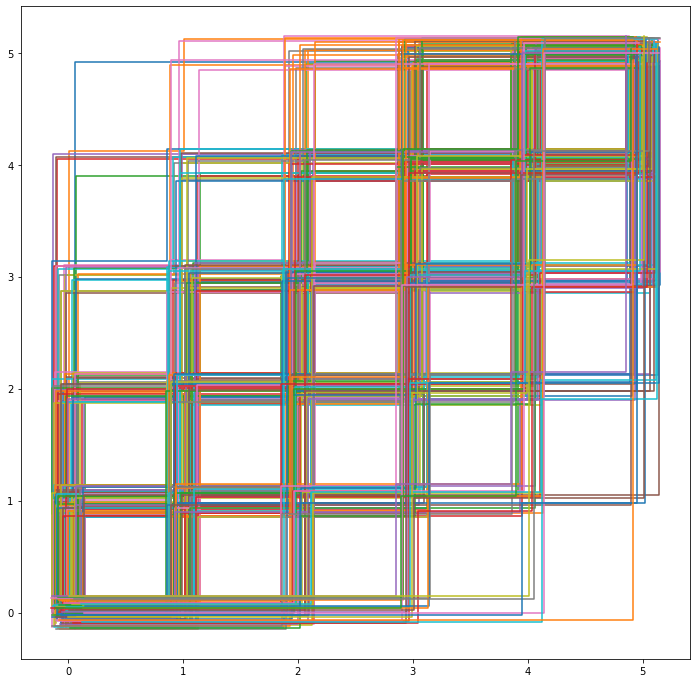

In [7]:
traj = randomTraj(int(1e4), x=5)
coord = plotTraj(traj, fuzz=.15, uniq=True)

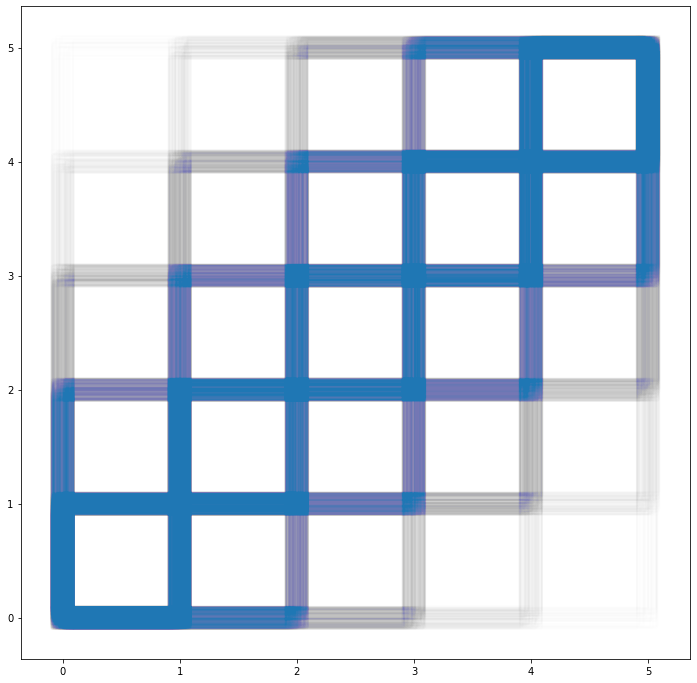

In [8]:
traj = randomTraj(int(1e4), x=5)
coord = plotTraj(traj, fuzz=.1, color='C0', alpha=.005)

# Expected length of coin flip sequence terminating in two consequetive heads


### stochastic brute force solution for $E(x)$

In [2]:
def flips(n=int(1e6)):
    flip = ''.join(np.random.choice(('0', '1'), size=n).tolist()).split('11')
    
    # re-append the '11' and censor the final sequence
    return ['11' + f for f in flip[:-1]]

def binLen(flip, density=False):
    count = np.bincount([len(f) for f in flip])
    
    return count/len(flip) if density else count

def stochastic(n=int(1e6)):
    lens = binLen(flips(n=n))
    return lens @ np.arange(lens.size)/lens.sum()

In [3]:
stochastic()

5.99676173570966

[0.         0.         0.24934837 0.12539655 0.12445747 0.09298042
 0.07867759 0.06332733 0.04998766 0.04118083 0.03312044 0.0269081
 0.02119539 0.01734278 0.01427875]


<BarContainer object of 15 artists>

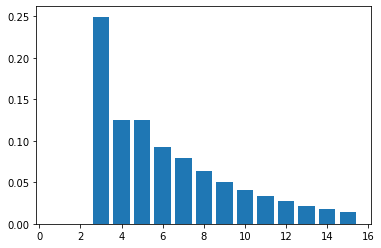

In [24]:
y = binLen(flips(), density=True)[:15]
print(y)
plt.bar(np.arange(1, y.size + 1), y)

### probability of some sequence lengths

\begin{align}
p(1) &= 0 \\
p(2) &= \frac{1}{2} \frac{1}{2} = \frac{1}{4} \\
p(3) &= \frac{1}{2} \frac{1}{4} = \frac{1}{8} \\
p(4) &= 2 \frac{1}{2} \frac{1}{8} = \frac{1}{8} \\
p(5) &= [1 - p(2)] \frac{1}{8} = \frac{3}{4} \frac{1}{8} = \frac{3}{32} \\
p(6) &= [1 - (p(2) + p(3))] \frac{1}{8} = \frac{5}{8} \frac{1}{8} = \frac{5}{64} \\
\end{align}

### recursive probability formula for $x > 3$

\begin{align}
p(x) = [1 - \sum_{y = 1}^{x - 3} p(y)] \frac{1}{8},\ \ \ \ x > 3
\end{align}

### numerical approximation to the recursive formula

In [19]:
_probCache = {1: 0, 2: 1/4, 3: 1/8}
def prob(x):
    if x < 1:
        return 0
    if x in _probCache:
        return _probCache[x]
    
    p = (1/8)*(1 - sum(prob(y) for y in range(2, x - 2)))

    _probCache[x] = p
    return p

def numerical(X=int(1e3)):
    return sum(x * prob(x) for x in range(1, X))

In [22]:
[prob(x) for x in np.arange(1, 15)]

[0,
 0.25,
 0.125,
 0.125,
 0.09375,
 0.078125,
 0.0625,
 0.05078125,
 0.041015625,
 0.033203125,
 0.02685546875,
 0.021728515625,
 0.017578125,
 0.01422119140625]

In [16]:
numerical()

6.000000000013359

### numerical vs stochastic

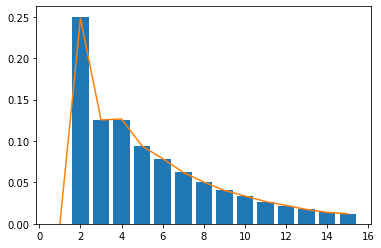

In [27]:
n = 15
x = np.arange(1, n + 1)
y0 = [prob(var) for var in x]
y1 = binLen(flips(), density=True)[1:n + 1]

fig = plt.figure()
ax = fig.gca()
ax.bar(x, y0)
ax.plot(x, y1, c='C1')

# Scratch

In [ ]:
def trajCoord(traj):
#     coord = np.zeros((2, traj.shape[0] + 1, traj.shape[1]), dtype=np.uint8)
#     coord[:, 1:, :] = (np.arange(2, dtype=np.uint8)[:, None, None] ^ bit[None, ...]).cumsum(axis=1)
    
#     return coord

#     conv = np.zeros((2, bit.shape[0]), dtype=np.uint8)
#     conv[1, 1:] = 1
    
#     return (conv[..., None] ^ bit[None, ...]).cumsum(axis=1)

#     return (np.arange(2, dtype=np.uint8)[:, None, None] ^ bit[None, ...]).cumsum(axis=1)


In [53]:
arr = np.arange(2)[:, None, None] - gridtraj(100)
print(arr.shape)
arr

(2, 100, 10)


array([[[ 0, -1,  0, ..., -1, -1,  0],
        [-1,  0, -1, ...,  0,  0, -1],
        [ 0,  0, -1, ..., -1,  0, -1],
        ...,
        [ 0, -1,  0, ..., -1,  0, -1],
        [ 0, -1, -1, ..., -1,  0,  0],
        [ 0, -1,  0, ..., -1,  0, -1]],

       [[ 1,  0,  1, ...,  0,  0,  1],
        [ 0,  1,  0, ...,  1,  1,  0],
        [ 1,  1,  0, ...,  0,  1,  0],
        ...,
        [ 1,  0,  1, ...,  0,  1,  0],
        [ 1,  0,  0, ...,  0,  1,  1],
        [ 1,  0,  1, ...,  0,  1,  0]]])

In [59]:
traj = gridTraj(int(3), x=5)
print(traj.shape)
print(trajCoord(traj).shape)

(10, 3)
(2, 11, 3)


In [80]:
fuzz = .2

traj = gridTraj(int(100), x=5)
coord = trajCoord(traj, fuzz=0)

fuzzed = coord + np.random.uniform(-fuzz, fuzz, size=(coord.shape[0], coord.shape[2]))[:, None, :]
fuzzed[:, :, :3]

array([[[ 0.1447698 , -0.14971525, -0.12135943],
        [ 0.1447698 ,  0.85028475, -0.12135943],
        [ 1.1447698 ,  0.85028475, -0.12135943],
        [ 1.1447698 ,  1.85028475, -0.12135943],
        [ 2.1447698 ,  2.85028475,  0.87864057],
        [ 2.1447698 ,  3.85028475,  1.87864057],
        [ 2.1447698 ,  3.85028475,  1.87864057],
        [ 3.1447698 ,  4.85028475,  1.87864057],
        [ 4.1447698 ,  4.85028475,  2.87864057],
        [ 5.1447698 ,  4.85028475,  3.87864057],
        [ 5.1447698 ,  4.85028475,  4.87864057]],

       [[-0.00635294, -0.19915433,  0.15598262],
        [ 0.99364706, -0.19915433,  1.15598262],
        [ 0.99364706,  0.80084567,  2.15598262],
        [ 1.99364706,  0.80084567,  3.15598262],
        [ 1.99364706,  0.80084567,  3.15598262],
        [ 2.99364706,  0.80084567,  3.15598262],
        [ 3.99364706,  1.80084567,  4.15598262],
        [ 3.99364706,  1.80084567,  5.15598262],
        [ 3.99364706,  2.80084567,  5.15598262],
        [ 3.993647

In [82]:
binned,counts = binTraj(traj)

In [83]:
counts

array([2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

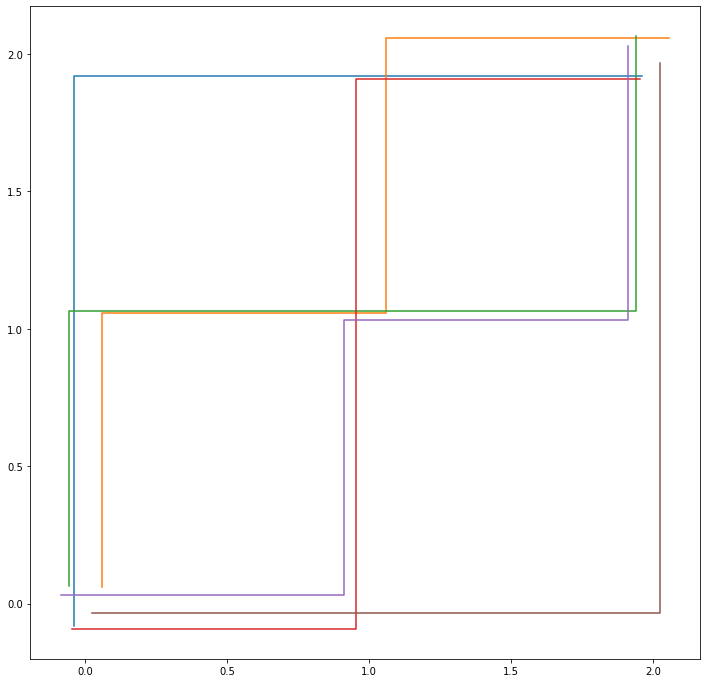

In [155]:
traj = gridTraj(20, x=2)
coord = plotTraj(traj, fuzz=.1, uniq=True)

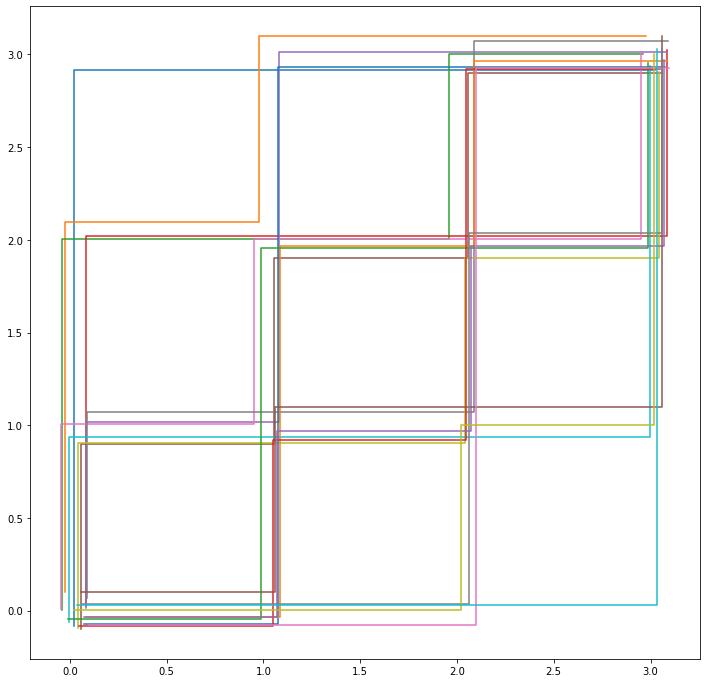

In [156]:
traj = gridTraj(100, x=3)
coord = plotTraj(traj, fuzz=.1, uniq=True)

### expected value (recursive formula)

\begin{align}
E(x) = \sum x p(x) \\
E(x) = 1 + \frac{2}{4} + \frac{3}{8} + \sum_{x > 3} x p(x) \\
E(x) = \frac{15}{8} + \sum_{x > 3} x p(x) \\
E(x) = \frac{15}{8} + \frac{1}{8} \sum_{x > 3} \left[ x - x p(x - 3) \right] \\
E(x) = \frac{1}{8} \sum_{x > 3} \left[ x - x p(x - 3) \right] - \frac{15}{8} \\
\end{align}

In [231]:
flip = np.random.choice(('0', '1'), size=int(1e6))
print(flip)
arr = np.array([len(s) for s in ''.join(flip.tolist()).split('11')])
arr.mean()

['0' '1' '0' ... '0' '0' '0']


3.982590695893558

In [192]:
parr = np.zeros((arr.shape[0] + 2,), dtype=arr.dtype)
parr[2:] = arr[:]

In [222]:
~np.diff(arr, append=0) & arr

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [220]:
(np.diff(~np.diff(arr, append=0) & arr, prepend=0) > 0).nonzero()[0]

array([0, 5, 9])

In [207]:
np.diff(arr, append=0)

array([-1,  1, -1,  0,  1, -1,  1,  0, -1,  0])

In [198]:
parr

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0], dtype=int8)

In [248]:
def flips(n=int(1e6)):
    flip = []
    acc = ''
    for x in np.random.choice(('0', '1'), size=n):
        acc += x
        if acc[-2:] == '11':
            flip.append(acc)
            acc = ''
            
    return flip

def lenbin(flip, density=False):
    count = np.bincount([len(f) for f in flip])
    
    return count/len(flip) if density else count

def stochastic(n=int(1e6)):
    lens = lenbin(flips(n=n))
    return lens @ np.arange(lens.size)/lens.sum()

In [249]:
stochastic()

6.009525125899929